### В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.<a id="description"></a>

1. [Откройте файл с данными и изучите общую информацию](#step_1)
2. [Подготовьте данные](#step_2)
3. [Проанализируйте данные](#step_3)
4. [Проверьте гипотезы](#step_4)
5. [Напишите общий вывод](#step_5)

### Описание тарифов:<a id='step_1'></a>

#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

#### Примечание 
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.
- Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

---

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
users = pd.read_csv('users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [3]:
calls = pd.read_csv('calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


#### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [4]:
messages = pd.read_csv('messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


#### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

<a id='tariff_description'></a>

In [5]:
tariffs = pd.read_csv('tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

[К гистограммам](#hist)

In [6]:
internet = pd.read_csv('internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


#### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

---

[к началу](#description)

- Приведите данные к нужным типам; <a id='step_2'></a>
- Найдите и исправьте ошибки в данных, если они есть.
- Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять. 

Провери данные users:
- Какие типы нужно изменить
- проверим данные на NaN
- посмотрим минимальный и максимальный возраст, чтобы там не было не корректных значений
- приведем строковые значения к нижнему регистру, чтобы избежать дубликатов

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим данные на NaN

In [8]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

Проверим нижнюю и верхнюю границу возраста

In [9]:
users.age.describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

churn_date, reg_date переведем в datetime

In [10]:
users.reg_date = pd.to_datetime(users.reg_date)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [11]:
users.churn_date = pd.to_datetime(users.churn_date)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [12]:
lower_list = ['first_name', 'last_name', 'city']
for st in lower_list:
    users[st] = users[st].str.lower()
users[lower_list]

,first_name,last_name,city
0,рафаил,верещагин,краснодар
1,иван,ежов,москва
2,евгений,абрамович,стерлитамак
3,белла,белякова,москва
4,татьяна,авдеенко,новокузнецк
...,...,...,...
495,авксентий,фокин,иркутск
496,трифон,блохин,вологда
497,каролина,агеева,челябинск
498,всеволод,акимчин,владикавказ


In [13]:
len(users.user_id.unique())

500

In [14]:
users.user_id.duplicated().sum()

0

In [15]:
users.groupby('tariff').user_id.agg('count')

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

Проверим данные по звонкам
- проверим есть ли пустые значения
- в каких столбцах следует изменить тип
- есть ли дубликаты в id звонка
- округлим длительнось до большего целого, тк при подсчете секунды округляются до большего целого

In [16]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [18]:
calls.call_date = pd.to_datetime(calls.call_date)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [19]:
calls.id.duplicated().sum()

0

In [20]:
calls[calls.duration < 0].id.count()

0

In [21]:
calls['ceil_duration'] = calls.duration.apply(lambda x: math.ceil(x))

In [22]:
calls[['duration', 'ceil_duration']].head()

,duration,ceil_duration
0,0.00,0
1,0.00,0
2,2.85,3
3,13.80,14
4,5.18,6


Проверим messages:
- проверим пропуски
- проверим тип
- уникальность id сообщения

In [23]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [24]:
messages.id.duplicated().sum()

0

In [25]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [26]:
messages.message_date = pd.to_datetime(messages.message_date)
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Проверим internet:
- проверим пропуски
- проверим тип
- уникальность номер сессии
- отрицательный объем

In [27]:
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Неизвестный столбец Unnamed: 0 дропнем, тк его применение не очевино и он не был заявлен в данных

In [28]:
internet.drop(columns='Unnamed: 0', inplace=True)
internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

In [29]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [30]:
internet.session_date = pd.to_datetime(internet.session_date)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [31]:
internet.id.duplicated().sum()

0

In [32]:
internet[internet.mb_used < 0 ].user_id.count()


0

 изменим в tariffs мб на гб, тк в тарифах все равно округляются мб до целых гб

In [33]:
tariffs['gb_month_included'] =  tariffs.mb_per_month_included.apply(lambda x: (x/1024))
tariffs[['mb_per_month_included', 'gb_month_included']]

,mb_per_month_included,gb_month_included
0,15360,15.0
1,30720,30.0


#### Посчитайте для каждого пользователя:

- [количество сделанных звонков и израсходованных минут разговора по месяцам;](#calls)
- [количество отправленных сообщений по месяцам;](#message)
- [объем израсходованного интернет-трафика по месяцам;](#month_internet)
- [помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).](#proceeds_of_user)

Добавим новый столбец с месяцем и годом, чтобы было удобнее делить звонки по месяцам

In [34]:
#calls.groupby('user_id').duration.agg(['sum'])
calls['month'] = calls.call_date.dt.to_period('M')
calls[['month', 'call_date']].head()
calls.month.unique()

<PeriodArray>
['2018-07', '2018-08', '2018-06', '2018-09', '2018-12', '2018-11', '2018-10',
 '2018-05', '2018-03', '2018-04', '2018-01', '2018-02']
Length: 12, dtype: period[M]

количество сделанных звонков и израсходованных минут разговора по месяцам; <a id='calls'></a>
- сгруппируем по user_id и month
- переименуем столбцы

In [35]:
all_calls = calls.groupby(['user_id', 'month']).ceil_duration.agg(['sum', 'count']).reset_index()
#all_calls = calls.pivot_table(index='user_id', columns='month', values='ceil_duration', aggfunc=['sum', 'count'])

In [36]:
all_calls.columns = ['user_id', 'month', 'duration_calls', 'count_calls']
all_calls.head(10)


,user_id,month,duration_calls,count_calls
0,1000,2018-05,159,22
1,1000,2018-06,172,43
2,1000,2018-07,340,47
3,1000,2018-08,408,52
4,1000,2018-09,466,58
5,1000,2018-10,350,57
6,1000,2018-11,338,43
7,1000,2018-12,333,46
8,1001,2018-11,430,59
9,1001,2018-12,414,63


количество отправленных сообщений по месяцам;<a id='message'></a>
сделаем то же самое, чтот и выше

In [37]:
messages['month'] = messages.message_date.dt.to_period('M')

messages[['month', 'message_date']].head()

,month,message_date
0,2018-06,2018-06-27
1,2018-10,2018-10-08
2,2018-08,2018-08-04
3,2018-06,2018-06-16
4,2018-12,2018-12-05


In [38]:
all_messages = messages.groupby(['user_id', 'month']).id.agg(['count']).reset_index()
all_messages.columns = all_messages.columns.str.replace('count', 'message_count')
all_messages.head(10)

,user_id,month,message_count
0,1000,2018-05,22
1,1000,2018-06,60
2,1000,2018-07,75
3,1000,2018-08,81
4,1000,2018-09,57
5,1000,2018-10,73
6,1000,2018-11,58
7,1000,2018-12,70
8,1002,2018-06,4
9,1002,2018-07,11


объем израсходованного интернет-трафика по месяцам<a id='month_internet'> </a>:
- сделаем столбец с месяцами
- округлим до наибольшего целого гб

In [39]:
internet['month'] = internet.session_date.dt.to_period('M')
internet[['month', 'session_date']].head()


,month,session_date
0,2018-11,2018-11-25
1,2018-09,2018-09-07
2,2018-06,2018-06-25
3,2018-08,2018-08-22
4,2018-09,2018-09-24


In [40]:

month_internet = internet.groupby(['user_id', 'month']).mb_used.agg(['sum']).reset_index()
month_internet['gb_used'] = month_internet['sum'].apply(lambda x: math.ceil(x/1024))

month_internet.drop('sum', axis=1, inplace=True)
month_internet.head(12)

,user_id,month,gb_used
0,1000,2018-05,3
1,1000,2018-06,23
2,1000,2018-07,14
3,1000,2018-08,14
4,1000,2018-09,15
5,1000,2018-10,15
6,1000,2018-11,15
7,1000,2018-12,10
8,1001,2018-11,18
9,1001,2018-12,14


- сделаем переменную с нужными нам столбцами из users
- проверим количество уникальных id в каждом тарифе чтобы их не потерять

In [41]:
user_info = users[['user_id', 'tariff', 'age', 'city', 'churn_date']]
user_info.head()

,user_id,tariff,age,city,churn_date
0,1000,ultra,52,краснодар,NaT
1,1001,smart,41,москва,NaT
2,1002,smart,59,стерлитамак,NaT
3,1003,ultra,23,москва,NaT
4,1004,ultra,68,новокузнецк,NaT


- раскидаем тарифы в отдельные переменные, чтобы с ними было удобнее работать
- объединим с остальными таблицами
- проверим количество уникальных id в каждой переменной

In [42]:
user_info.groupby('tariff').user_id.count()

tariff
smart    351
ultra    149
Name: user_id, dtype: int64

In [43]:
smart_users = user_info.query('tariff == "smart"').merge(all_calls, on=['user_id'], how='left')
smart_users = smart_users.merge(month_internet, on=['user_id', 'month'], how='left')
smart_users = smart_users.merge(all_messages, on=['user_id', 'month'], how='left')

len(smart_users.user_id.unique())

351

In [44]:
smart_users.head()

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count
0,1001,smart,41,москва,NaT,2018-11,430.0,59.0,18.0,NaN
1,1001,smart,41,москва,NaT,2018-12,414.0,63.0,14.0,NaN
2,1002,smart,59,стерлитамак,NaT,2018-06,117.0,15.0,11.0,4.0
3,1002,smart,59,стерлитамак,NaT,2018-07,214.0,26.0,18.0,11.0
4,1002,smart,59,стерлитамак,NaT,2018-08,289.0,42.0,20.0,13.0


In [45]:
ultra_users = user_info.query('tariff == "ultra"').merge(all_calls, on=['user_id'], how='left')
ultra_users = ultra_users.merge(month_internet, on=['user_id', 'month'], how='left')
ultra_users = ultra_users.merge(all_messages, on=['user_id', 'month'], how='left')

len(ultra_users.user_id.unique())

149

In [46]:
ultra_users.head()

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count
0,1000,ultra,52,краснодар,NaT,2018-05,159.0,22.0,3.0,22.0
1,1000,ultra,52,краснодар,NaT,2018-06,172.0,43.0,23.0,60.0
2,1000,ultra,52,краснодар,NaT,2018-07,340.0,47.0,14.0,75.0
3,1000,ultra,52,краснодар,NaT,2018-08,408.0,52.0,14.0,81.0
4,1000,ultra,52,краснодар,NaT,2018-09,466.0,58.0,15.0,57.0


помесячная выручка <a id='proceeds_of_user'></a>

Чтобы посчитать ежемесячную выручку с каждого клиента напишем функцию, а затем применим ее к каждой переменной

In [47]:
def proceeds_of_user(gb_used, duration_calls, message_count, tariff):
    i = 0
    total_gb = 0
    total_calls = 0
    total_message = 0
    
    if tariff == 'ultra':
        i = 1
        
    if gb_used > tariffs.gb_month_included[i]:
        total_gb = (gb_used - tariffs.gb_month_included[i]) * tariffs.rub_per_gb[i]
    if duration_calls > tariffs.minutes_included[i]:
        total_calls = (duration_calls - tariffs.minutes_included[i]) * tariffs.rub_per_minute[i]
    if message_count > tariffs.messages_included[i]:
        total_message = (message_count - tariffs.messages_included[i]) * tariffs.rub_per_message[i]
    return total_gb + total_calls + total_message + tariffs.rub_monthly_fee[i]


In [48]:
ultra_users['proceeds'] = ultra_users.apply(lambda x: 
                                      proceeds_of_user(x['gb_used'], 
                                                       x['duration_calls'], 
                                                       x['message_count'], 
                                                       x['tariff']), axis=1)


In [49]:
ultra_users.sort_values('message_count', ascending=False).head(10)

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count,proceeds
271,1165,ultra,19,самара,NaT,2018-12,278.0,37.0,32.0,224.0,2250.0
52,1028,ultra,20,тверь,NaT,2018-10,954.0,138.0,22.0,223.0,1950.0
270,1165,ultra,19,самара,NaT,2018-11,232.0,34.0,42.0,197.0,3750.0
513,1300,ultra,40,москва,NaT,2018-10,731.0,111.0,38.0,191.0,3150.0
278,1167,ultra,30,кемерово,NaT,2018-10,727.0,97.0,16.0,190.0,1950.0
515,1300,ultra,40,москва,NaT,2018-12,623.0,97.0,35.0,183.0,2700.0
53,1028,ultra,20,тверь,NaT,2018-11,1021.0,133.0,18.0,182.0,1950.0
15,1004,ultra,68,новокузнецк,NaT,2018-07,135.0,22.0,22.0,181.0,1950.0
280,1167,ultra,30,кемерово,NaT,2018-12,841.0,114.0,25.0,178.0,1950.0
512,1300,ultra,40,москва,NaT,2018-09,725.0,96.0,33.0,176.0,2400.0


In [50]:
ultra_users.isna().sum()

user_id             0
tariff              0
age                 0
city                0
churn_date        880
month               6
duration_calls      6
count_calls         6
gb_used            16
message_count     195
proceeds            0
dtype: int64

In [103]:
ultra_users.fillna(value={'message_count': 0, 'duration_calls': 0, 'count_calls': 0, 'gb_used': 0}, inplace=True)

In [104]:
ultra_users.isna().sum()

user_id             0
tariff              0
age                 0
city                0
churn_date        880
month               6
duration_calls      0
count_calls         0
gb_used             0
message_count       0
proceeds            0
dtype: int64

In [51]:
ultra_users[ultra_users.month.isna()]

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count,proceeds
151,1091,ultra,36,набережные челны,NaT,NaT,NaN,NaN,NaN,NaN,1950.0
197,1106,ultra,67,калуга,NaT,NaT,NaN,NaN,NaN,NaN,1950.0
228,1128,ultra,51,волжский,2018-12-23,NaT,NaN,NaN,NaN,NaN,1950.0
380,1231,ultra,63,чебоксары,NaT,NaT,NaN,NaN,NaN,NaN,1950.0
554,1328,ultra,44,мурманск,NaT,NaT,NaN,NaN,NaN,NaN,1950.0
929,1473,ultra,18,красноярск,NaT,NaT,NaN,NaN,NaN,NaN,1950.0


In [52]:
smart_users['proceeds'] = smart_users.apply(lambda x: 
                                      proceeds_of_user(x['gb_used'], 
                                                       x['duration_calls'], 
                                                       x['message_count'], 
                                                       x['tariff']), axis=1)


In [53]:
smart_users.sort_values('message_count', ascending=False).head(10)

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count,proceeds
499,1112,smart,51,ульяновск,NaT,2018-12,544.0,75.0,22.0,143.0,2361.0
1487,1324,smart,25,череповец,NaT,2018-10,838.0,117.0,27.0,139.0,4231.0
1484,1324,smart,25,череповец,NaT,2018-07,719.0,97.0,20.0,137.0,2468.0
1486,1324,smart,25,череповец,NaT,2018-09,715.0,107.0,23.0,136.0,3053.0
1483,1324,smart,25,череповец,NaT,2018-06,757.0,114.0,26.0,134.0,3773.0
1485,1324,smart,25,череповец,NaT,2018-08,782.0,104.0,24.0,134.0,3448.0
985,1212,smart,21,саранск,NaT,2018-12,443.0,72.0,22.0,129.0,2187.0
2167,1484,smart,55,екатеринбург,NaT,2018-10,369.0,48.0,14.0,127.0,781.0
1489,1324,smart,25,череповец,NaT,2018-12,754.0,101.0,20.0,125.0,2537.0
1488,1324,smart,25,череповец,NaT,2018-11,535.0,93.0,21.0,124.0,2077.0


In [54]:
smart_users.isna().sum()

user_id              0
tariff               0
age                  0
city                 0
churn_date        2113
month                2
duration_calls       2
count_calls          2
gb_used              3
message_count      309
proceeds             0
dtype: int64

In [101]:
smart_users.fillna(value={'message_count': 0, 'duration_calls': 0, 'count_calls': 0, 'gb_used': 0}, inplace=True)

In [102]:
smart_users.isna().sum()

user_id              0
tariff               0
age                  0
city                 0
churn_date        2113
month                2
duration_calls       0
count_calls          0
gb_used              0
message_count        0
proceeds             0
dtype: int64

In [63]:
all_data = pd.concat([smart_users, ultra_users]).reset_index()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           3182 non-null   int64         
 1   user_id         3182 non-null   int64         
 2   tariff          3182 non-null   object        
 3   age             3182 non-null   int64         
 4   city            3182 non-null   object        
 5   churn_date      189 non-null    datetime64[ns]
 6   month           3174 non-null   period[M]     
 7   duration_calls  3174 non-null   float64       
 8   count_calls     3174 non-null   float64       
 9   gb_used         3163 non-null   float64       
 10  message_count   2678 non-null   float64       
 11  proceeds        3182 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(2), period[M](1)
memory usage: 298.4+ KB


In [64]:
len(all_data.user_id.unique())

500

---

[к началу](#description)

### Опишите поведение клиентов оператора, исходя из выборки.
1. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
2. Посчитайте:
    - среднее количество,
    - дисперсию и стандартное отклонение.
    - Постройте гистограммы.
    - Опишите распределения.
<a id='step_3'></a>

### Считаем среднее, дисперсию и стандартное отклонение

Делаем таблицу со средним по 4 основным столбцам

In [74]:
round(all_data.groupby('tariff')[['gb_used', 'duration_calls', 'message_count', 'proceeds']].agg(['mean', 'median']))

gb_used        duration_calls        message_count        proceeds  \
          mean median           mean median          mean median     mean   
tariff                                                                      
smart     16.0   17.0          419.0  423.0          39.0   34.0   1290.0   
ultra     20.0   19.0          545.0  528.0          61.0   52.0   2070.0   

                
        median  
tariff          
smart   1023.0  
ultra   1950.0

Исходя из таблицы, пользователям тарифа смарт не хватает бесплатного лимита гигабайтов, а пользователям тарифа ультра опций в избытке

Между значением медиан и средних в тарифе ультра в большую сторону всегда отклоняется среднее относительно медианы, возможно в тарифе ультра больше выбросов которые сильнее влияют на среднее значение.
В тарифе смарт не значительная разница между средним и медианным значением, не считая proceeds

---

#### Дисперсия и стандартное отклонение для тарифов:

In [136]:
d_ultra = [round(np.var(ultra_users[x]), 1) for x in ['gb_used', 'duration_calls', 'message_count', 'proceeds']]
s_ultra = np.sqrt(d_ultra)

ds_ultra = pd.DataFrame([d_ultra, s_ultra], index=['d_utra', 's_ultra'], columns=['gb_used_ultra', 'duration_calls_ultra', 'message_count_ultra', 'proceeds_ultra'])
ds_ultra

,gb_used_ultra,duration_calls_ultra,message_count_ultra,proceeds_ultra
d_utra,94.700000,94104.400000,1996.900000,143000.300000
s_ultra,9.731393,306.764405,44.686687,378.153805


Отклонение в тарифе ультра большие, следовательно и большая разница между каждым конкретным значением и средним. 
Дисперсия большая относительно всех показателей, следовательно и большая степень разброса значений величин относительно их математического ожидания

In [137]:
d_smart = [round(np.var(smart_users[x]), 1) for x in ['gb_used', 'duration_calls', 'message_count', 'proceeds']]
s_smart = np.sqrt(d_smart)

ds_smart = pd.DataFrame([d_smart, s_smart], index=['d_smart', 'd_smart'], columns=['gb_used_smart', 'duration_calls_smart', 'message_count_smart', 'proceeds_smart'])
ds_smart

,gb_used_smart,duration_calls_smart,message_count_smart,proceeds_smart
d_smart,33.000000,35828.100000,718.800000,670545.600000
d_smart,5.744563,189.283121,26.810446,818.868488


- Высокое отклонение относительно тарифа ультра у выручки в тарифе смарт, при этом если сравнивать с тарифом ультра, по остальным показателям разброс отклонений в тарифе смарт намного ниже
- Дисперсия высокая, но относительно тарифа ультра ее разброс намного меньше, не считая выручки

---

В тарифе ультра довольно большое отклонения между значениями и средним, в отличие от смарт, при этом данных для тарифа смарт почти вдвое больше, таким образом более низкие показатели отклонения и дисперсии в тарифе смарт можно объяснить большим размером выборки

#### Распреление данных на гистаграммах

#### синий: smart;
#### красный: ultra; <a id='hist'></a>

[Описание тарифа](#tariff_description)

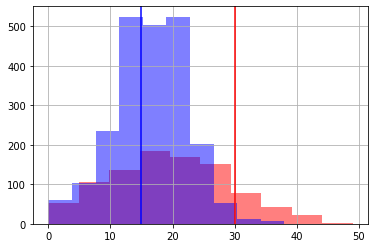

In [142]:
ultra_gb = tariffs.query('tariff_name == "ultra"').reset_index().gb_month_included[0]
smart_gb = tariffs.query('tariff_name == "smart"').reset_index().gb_month_included[0]

ultra_users.gb_used.hist(alpha=0.5, color='red')
smart_users.gb_used.hist(alpha=0.5, color='blue')
plt.axvline(x=ultra_gb, color ='red')
plt.axvline(x=smart_gb, color ='blue')


plt.show()

По гистаграме можно предположить:
- большая часть пользователей тарифа smart выходит за пределы бесплатного лимита интернета
- На тарифе ультра большей части клиентов достаточно бесплатного лимита

In [80]:
print(f'За год пользователи тарифа smart в {round(smart_users.query("gb_used > 15").user_id.count()/len(smart_users) * 100, 2)} % превысили бесплатный лимит гб')
print(f'И только {round(smart_users.query("gb_used <= 15").user_id.count()/len(smart_users) * 100, 2)} % за год пользователи не превысили бесплатного лимита ')

За год пользователи тарифа smart 58.43 % превысили бесплатный лимит гб
И только 41.44 % за год пользователи не превысили бесплатного лимита 


In [81]:
print(f'За год пользователи тарифа ultra в {round(ultra_users.query("gb_used > 30").user_id.count()/len(ultra_users) * 100, 2)} % превысили бесплатный лимит гб')
print(f'И {round(ultra_users.query("gb_used <= 30").user_id.count()/len(ultra_users) * 100, 2)} % за год пользователи не превысили бесплатного лимита ')

За год пользователи тарифа ultra 13.38 % превысили бесплатный лимит гб
И 84.95 % за год пользователи не превысили бесплатного лимита 


---

Чтобы предположить какой объем интернет трафика требуется пользователям каждого тарифа в месяц, возьмем значения по 80 процентилю, чтобы только 20% были за границей лимита

In [145]:
#print(f'{math.ceil(stats.trim_mean(smart_users.gb_used, 0.1))}')
np.percentile(smart_users.gb_used.fillna(0), 80)

21.0

In [146]:
#math.ceil(stats.trim_mean(ultra_users.gb_used, 0.1))
np.percentile(ultra_users.gb_used.fillna(0), 80)

28.0

Если не обращать внимания на отдельные выбросы, 21гб для пользователей тарифа smart И 28гб для тарифа ultra были бы оптимальны.

[Описание тарифа](#tariff_description)

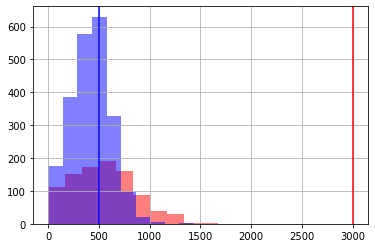

In [151]:
ultra_min = tariffs.query('tariff_name == "ultra"').reset_index().minutes_included[0]
smart_min = tariffs.query('tariff_name == "smart"').reset_index().minutes_included[0]

ultra_users.duration_calls.hist(alpha=0.5, color='red')
smart_users.duration_calls.hist(alpha=0.5, color='blue')
plt.axvline(x=ultra_min, color ='red')
plt.axvline(x=smart_min, color ='blue')
plt.show()

- На тарифе смарт все еще достаточно часто клиенты общаются дольше, чем им позволяет бесплатный лимит
- На тарифе ультра напротив, подавляющее количество раз, клиенты даже не доходят до лимита длительности звонков

In [105]:
print(f'За год пользователи тарифа smart в {round(smart_users.query("duration_calls > 500").user_id.count()/len(smart_users) * 100, 2)} % превысили бесплатный лимит минут')
print(f'И {round(smart_users.query("duration_calls <= 500").user_id.count()/len(smart_users)* 100, 2) } % за год пользователи не превысили бесплатного лимита ')

За год пользователи тарифа smart в 33.89 % превысили бесплатный лимит минут
И 66.11 % за год пользователи не превысили бесплатного лимита 


In [106]:
print(f'За год пользователи тарифа ultra в {round(ultra_users.query("duration_calls > 3000").user_id.count()/len(ultra_users), 2)} % превысили бесплатный лимит минут')
print(f'И {round(ultra_users.query("duration_calls <= 3000").user_id.count()/len(ultra_users) * 100, 2)} % за год пользователей не превысили бесплатного лимита ')

За год пользователи тарифа ultra в 0.0 % превысили бесплатный лимит минут
И 100.0 % за год пользователи не превысили бесплатного лимита 


Посчитаем так же как и в интернет-трафике 80 процентиль, чтобы понять оптимальную длительность для телефонных разговоров

In [107]:
print(f'Для тарифа smart {np.percentile(smart_users.duration_calls.fillna(0), 80)} минут возможно было бы оптимально')

Для тарифа smart 576.0 минут возможно было бы оптимально


In [108]:
print(f'Для тарифа ultra {np.percentile(ultra_users.duration_calls.fillna(0), 80)} минут возможно было бы оптимально')

Для тарифа ultra 812.6000000000001 минут возможно было бы оптимально


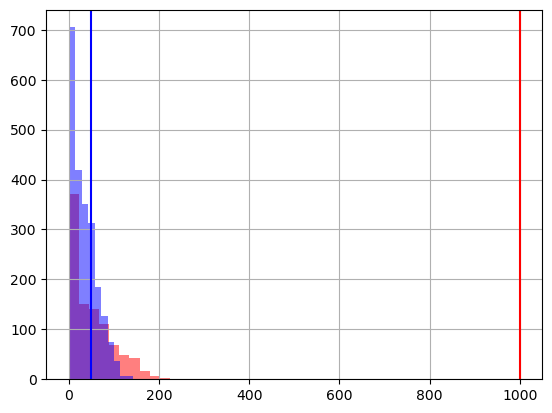

In [109]:
ultra_mess = tariffs.query('tariff_name == "ultra"').reset_index().messages_included[0]
smart_mess = tariffs.query('tariff_name == "smart"').reset_index().messages_included[0]

ultra_users.message_count.hist(alpha=0.5, color='red')
smart_users.message_count.hist(alpha=0.5, color='blue')

plt.axvline(x=ultra_mess, color ='red')
plt.axvline(x=smart_mess, color ='blue')
plt.show()

- по большей части пользователям тарифа smart хватает бесплатного лимита сообщений, но далеко не всем
- пользователям тарифа ультра бесплатного лимита сообщений хватает с избытком

In [110]:
print(f'За год пользователи тарифа smart в {round(smart_users.query("message_count > 50").user_id.count()/len(smart_users) * 100, 2)} % превысили бесплатный лимит сообщений')
print(f'И {round(smart_users.query("message_count <= 50").user_id.count()/len(smart_users) * 100, 2)} % за год пользователи не превысили бесплатного лимита ')

За год пользователи тарифа smart в 25.35 % превысили бесплатный лимит сообщений
И 74.65 % за год пользователи не превысили бесплатного лимита 


In [117]:
print(f'За год из пользователей тарифа ultra {round(ultra_users.query("message_count > 1000").user_id.count()/len(ultra_users)* 100, 2)} % превысили бесплатный лимит сообщений')
print(f'И {round(ultra_users.query("message_count <= 1000").user_id.count()/len(ultra_users)* 100, 2)} % за год пользователей не превысили бесплатного лимита ')

За год из пользователей тарифа ultra 0.0 % превысили бесплатный лимит сообщений
И 100.0 % за год пользователей не превысили бесплатного лимита 


In [115]:
print(f'Для тарифа smart {np.percentile(smart_users.message_count.fillna(0), 80)} сообщений возможно было бы оптимально')

Для тарифа smart 57.0 сообщений возможно было бы оптимально


In [116]:
print(f'Для тарифа ultra {np.percentile(ultra_users.message_count.fillna(0), 80)} cообщений возможно было бы оптимально')

Для тарифа ultra 87.80000000000007 cообщений возможно было бы оптимально


Пользователям тарифа смарт почти всегда не хватает опций включенных в пакет, в то время когда пользователи тарифа ультра часто даже близко не подходят к лимитам

---

Разделим клиентов на возрастные группы

In [161]:
def age_category(age):
    
    young = np.percentile(users.age, 25)
    adult = np.percentile(users.age, 50)
    old = np.percentile(users.age, 75)
    
    if age <= young:
        return 'young'
    elif (age > young) & (age <= adult):
        return 'adult'
    elif (age > adult) & (age <= old):
        return 'old'
    else:
        return 'elder'

In [162]:
all_data['age_category'] = all_data.age.apply(age_category)
all_data[['age', 'age_category']]

,age,age_category
0,52,old
1,52,old
2,52,old
3,52,old
4,52,old
...,...,...
3177,68,elder
3178,35,adult
3179,35,adult
3180,35,adult


посмотрим влияет ли как-то возраст, на частоту превышения лимитов. Для этого сделаем новый столбец overdraft, чтобы отметить булевыми значениями наличие выхода за лимит

In [163]:
def overdraft(proceeds, tariff):
    if (tariff == 'ultra') & (proceeds > 1950):
        return True
    elif(tariff == 'smart') & (proceeds > 550):
        return True
    return False

In [164]:
#all_data['overdraft'] = all_data.apply(lambda x: overdraft(x['proceeds'], x['tariff']), axis=1)
#all_data[['proceeds', 'tariff', 'overdraft']]

,proceeds,tariff,overdraft
0,1950.0,ultra,False
1,1950.0,ultra,False
2,1950.0,ultra,False
3,1950.0,ultra,False
4,1950.0,ultra,False
...,...,...,...
3177,1750.0,smart,True
3178,550.0,smart,False
3179,1150.0,smart,True
3180,1513.0,smart,True


In [165]:

all_data_ = all_data.merge(tariffs, left_on='tariff', right_on='tariff_name')
all_data_['overdraft'] = all_data_['proceeds'] > all_data_['rub_monthly_fee']

result = pd.concat([all_data_[['proceeds', 'tariff', 'overdraft']].head(), all_data_[['proceeds', 'tariff', 'overdraft']].tail()])
result

,proceeds,tariff,overdraft
0,1950.0,ultra,False
1,1950.0,ultra,False
2,1950.0,ultra,False
3,1950.0,ultra,False
4,1950.0,ultra,False
3177,1750.0,smart,True
3178,550.0,smart,False
3179,1150.0,smart,True
3180,1513.0,smart,True
3181,598.0,smart,True


----

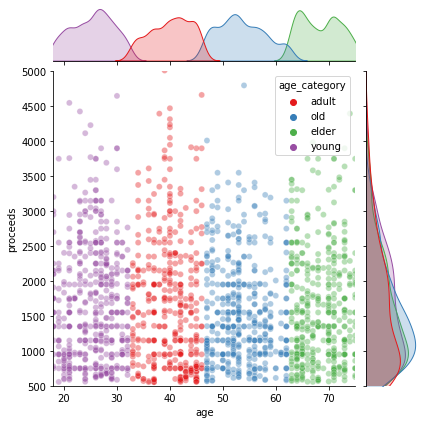

In [166]:
sns.jointplot(
    data=all_data.query('overdraft == True'),
    x='age', 
    y='proceeds', 
    hue='age_category', 
    palette='Set1',
    xlim = (18, 75),
    ylim = (500, 5000),
    alpha=0.4
)
plt.show()

In [167]:
all_data.groupby('age_category').agg({'overdraft': 'mean', 'proceeds': 'median'})

,overdraft,proceeds
age_category,,
adult,0.538961,1746.5
elder,0.572178,1701.5
old,0.564320,1488.0
young,0.569007,1750.0


In [168]:
young = np.percentile(users.age, 25)
adult = np.percentile(users.age, 50)
old = np.percentile(users.age, 75)
print(f' young: до {young}, adult: до {adult}, old: до {old}, elder: старше, чем {old}')

 young: до 32.0, adult: до 46.0, old: до 62.0, elder: старше, чем 62.0


Меньший процент с overdraft == True у категории 33-46, больший у 18-32. При этом самая меньшая медианная выручка с категории 47-62. Возможно так происходит потому что молодые люди много чаще пользуется всеми доступными услугами мобильной связи, чем более старшее поколение

In [170]:
all_data_['is_message_overdraft'] = all_data_['messages_included'] < all_data_['message_count']
all_data_['is_gb_overdraft'] = all_data_['gb_month_included'] < all_data_['gb_used']
all_data_['is_duration_calls_overdraft'] = all_data_['minutes_included'] < all_data_['duration_calls']

all_data_['everithing_overdraft']=all_data_['is_message_overdraft']*all_data_['is_gb_overdraft']*all_data_['is_duration_calls_overdraft']


all_data_.groupby('tariff').agg({
    'everithing_overdraft':'sum'
}).merge(all_data_.tariff.value_counts(), left_index=True, right_index=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


,everithing_overdraft,tariff
tariff,,
smart,164,2225
ultra,0,957


In [171]:
all_data_.groupby('tariff').agg({
    'is_duration_calls_overdraft':'sum',
    'is_gb_overdraft':'sum',
    'is_message_overdraft':'sum',
}).merge(all_data_.tariff.value_counts(), left_index=True, right_index=True)

,is_duration_calls_overdraft,is_gb_overdraft,is_message_overdraft,tariff
tariff,,,,
smart,754,1300,564,2225
ultra,0,128,0,957


- пользователи тарифа ультра выходят в овердрафт только по гб
- у пользователей тарифа смарт перерасход по всем услугам, наибольшие по гб, наименьшее по сообщениям.

Посмотрим на графике как в течении года изменяется выручка за разные тарифы. Для этого проиндексируем месяцы

In [174]:
all_data['month_index'] = abs(all_data.month.dt.month)
all_data[['month', 'month_index']].head()

,month,month_index
0,2018-05,5
1,2018-06,6
2,2018-07,7
3,2018-08,8
4,2018-09,9


In [175]:
all_data.month_index.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4])

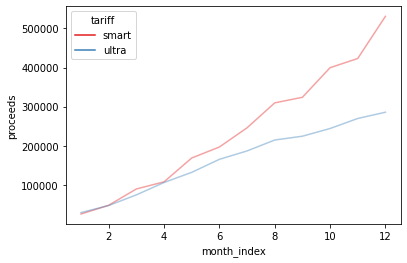

In [176]:
sns.lineplot(
    data=all_data.groupby(['month_index','tariff'], as_index=False).agg({
        'proceeds':'sum'
    }),
    x='month_index', 
    y='proceeds', 
    hue='tariff', 
    palette='Set1',
    alpha=0.4
)
plt.show()

In [177]:
all_data.groupby(['month_index','tariff'], as_index=False).agg({'proceeds':'sum', 'user_id': 'count'})

,month_index,tariff,proceeds,user_id
0,1,smart,25625.0,36
1,1,ultra,29250.0,15
2,2,smart,48001.0,58
3,2,ultra,47400.0,24
4,3,smart,89676.0,77
5,3,ultra,74550.0,37
6,4,smart,107866.0,112
7,4,ultra,106200.0,53
8,5,smart,168849.0,141
9,5,ultra,132150.0,64


По графику видно, что тариф смарт по сумме выручки привышает тариф ультра, возможно результаты могли бы отличатся, если бы у нас было одинаковое количество пользователей на двух тарифах

##### Кажется тариф смарт был создан для того чтобы люди за него переплачивали. Тем не менее, пользователи тарифа смарт все равно тратят по-большей части меньше, чем если бы они брали тариф ультра, возможно именно поэтому, они предпочитают оставаться на тарифе смарт, несмотря на недостаток объема опций. 

[к началу](#description)

#### Проверьте гипотезы <a id="step_4"></a>

1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Пороговое значение alpha задайте самостоятельно.
3. Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий? использовали для проверки гипотез и почему.

Чтобы применить метод для проверки двусторонней гипотезы, сформулируем гипотезу как:
#### средняя выручка пользователей тарифов «Ультра» и «Смарт» в генеральной совокупности равны;

In [185]:
print('cреднее по выручке тарифа смарт: ', smart_users_groupby_users.proceeds.mean())
print('cреднее по выручке тарифа ультра:', ultra_users_groupby_users.proceeds.mean())

cреднее по выручке тарифа смарт:  8178.777777777777
cреднее по выручке тарифа ультра: 13296.644295302014


В данном случае в наличии обе выборки и правильно использовать ttest_ind:

In [179]:
results = stats.ttest_ind(
    smart_users.proceeds, 
    ultra_users.proceeds,
    equal_var = False
)
results

Ttest_indResult(statistic=-36.72498605181482, pvalue=2.796424815525196e-246)

```equal_var = False``` – параметр, отвечающий за равенство дисперсий в двух выборках. Чаще всего он будет False, но в идеале чтобы проверить их равенство существуют определенные критерии, например, критерий Фишера:

In [180]:
# Считаем отношение большей дисперсии к меньшей

var_1 = np.var(smart_users.proceeds)
var_2 = np.var(ultra_users.proceeds)

F = var_2/var_1 if var_2>=var_1 else var_1/var_2
F, var_1, var_2

(4.689121640447828, 670545.6387373381, 143000.26532758033)

In [181]:
#степени свободы
lf1 = len(ultra_users.proceeds if var_2>=var_1 else smart_users.proceeds) - 1
lf2 = len(smart_users.proceeds if var_2>=var_1 else ultra_users.proceeds) - 1

lf1, lf2

(2224, 956)

In [182]:
# критерий фишера
p_value = stats.f.sf(F, lf1, lf2)
p_value

7.807046368021835e-137

In [183]:
if p_value < .05:
    print('Дисперсии не равны')

Дисперсии не равны


Также в задании указано: 
> средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются


In [184]:
smart_users_groupby_users = smart_users.groupby('user_id', as_index=False).agg({
    'proceeds':'sum'
})

ultra_users_groupby_users = ultra_users.groupby('user_id', as_index=False).agg({
    'proceeds':'sum'
})

In [186]:
print('Кол-во юзеров смарт: ', smart_users_groupby_users.user_id.count())
print('Кол-во юзеров ультра:', ultra_users_groupby_users.user_id.count())

Кол-во юзеров смарт:  351
Кол-во юзеров ультра: 149


In [187]:
results = stats.ttest_ind(
    smart_users_groupby_users.proceeds, 
    ultra_users_groupby_users.proceeds,
    equal_var = False
)
results

Ttest_indResult(statistic=-7.798927503192609, pvalue=2.3908110422749757e-13)

In [188]:
if results.pvalue < .05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


##### тест показал, что гипотезу о равенстве средней выручке пользователей тарифов «Ультра» и «Смарт» нужно отвергнуть, таким образом можно сделать вывод, что средняя выручка пользователей тарифов «Ультра» и «Смарт» может отличаться;

---

#### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Поступим так же как в примере выше, потому что вопрос сформулирован так же. Перед этим создадим переменные чтобы отделить мск от остальных регионов и затем посчитаем все так же как и выше

In [189]:
msk_users = all_data.query('city == "москва"')
msk_users.head()

,user_id,tariff,age,city,churn_date,month,duration_calls,count_calls,gb_used,message_count,proceeds,age_category,overdraft,month_index
8,1001,smart,41,москва,NaT,2018-11,430.0,59.0,18.0,NaN,1150.0,adult,True,11
9,1001,smart,41,москва,NaT,2018-12,414.0,63.0,14.0,NaN,550.0,adult,False,12
17,1003,ultra,23,москва,NaT,2018-08,380.0,55.0,9.0,37.0,1950.0,young,False,8
18,1003,ultra,23,москва,NaT,2018-09,961.0,134.0,13.0,91.0,1950.0,young,False,9
19,1003,ultra,23,москва,NaT,2018-10,855.0,108.0,15.0,83.0,1950.0,young,False,10


In [190]:
other_city_users = all_data.query('(city != "москва")')
other_city_users.city.unique()

array(['краснодар', 'стерлитамак', 'новокузнецк', 'набережные челны',
       'ульяновск', 'челябинск', 'пермь', 'тюмень', 'самара',
       'санкт-петербург', 'иваново', 'чебоксары', 'омск', 'уфа', 'томск',
       'чита', 'мурманск', 'петрозаводск', 'тверь', 'екатеринбург',
       'махачкала', 'вологда', 'череповец', 'ярославль', 'сочи',
       'хабаровск', 'ставрополь', 'рязань', 'улан-удэ', 'тула', 'саратов',
       'ростов-на-дону', 'казань', 'иркутск', 'курск', 'калуга', 'якутск',
       'астрахань', 'химки', 'владикавказ', 'волгоград', 'саранск',
       'ижевск', 'новосибирск', 'брянск', 'тольятти', 'нижний тагил',
       'орёл', 'белгород', 'воронеж', 'волжский', 'курган', 'барнаул',
       'красноярск', 'архангельск', 'липецк', 'кемерово', 'киров',
       'сургут', 'пенза', 'магнитогорск', 'нижний новгород', 'кострома',
       'владивосток', 'тамбов', 'балашиха', 'севастополь', 'калининград',
       'оренбург', 'смоленск', 'нижневартовск', 'владимир',
       'новороссийск', 'гроз

In [191]:
msk_sum = msk_users.groupby('user_id').proceeds.sum().reset_index()
other_city_sum = other_city_users.groupby('user_id').proceeds.sum().reset_index()
msk_sum.head(), other_city_sum.head()

(   user_id  proceeds
 0     1001    1700.0
 1     1003    9750.0
 2     1007    8221.0
 3     1031    1781.0
 4     1033   11484.0,
    user_id  proceeds
 0     1000   15600.0
 1     1002    7250.0
 2     1004   15600.0
 3     1005    9924.0
 4     1006   10250.0)

In [192]:
len(msk_sum)

99

In [193]:
len(other_city_sum)

401

In [194]:
d_1 = np.var(msk_sum.proceeds)
d_2 = np.var(other_city_sum.proceeds)
d_1, d_2

(43259431.07805327, 40874676.920815125)

Так как мы смотрим дисперсию суммы выручки без фильтрации по тарифам, то значение дисперсий адекватные

In [196]:
var_ratio = d_2/d_1 if d_2 >= d_1 else d_1/d_2
var_ratio, d_1, d_2

(1.058343070499567, 43259431.07805327, 40874676.920815125)

In [200]:
df_1 = len(msk_sum) -1
df_2 = len(other_city_sum) - 1

In [199]:
if stats.f.sf(var_ratio, df_1, df_2) < .05:
    print('Дисперсии не равны')
else:
    print('Дисперсии возможно равны')

Дисперсии возможно равны


Сформулируем нулевую гипотезу как:
##### средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

In [141]:
print(f'средняя сумма выручки пользователей в Москве', msk_sum.proceeds.mean())
print(f'средняя сумма выручки пользователей из всех городов, кроме Москвы',other_city_sum.proceeds.mean())

средняя сумма выручки пользователей в Москве 9526.181818181818
средняя сумма выручки пользователей из всех городов, кроме Москвы 9747.778054862843


In [139]:
alpha = .05
results = stats.ttest_ind(msk_sum.proceeds, other_city_sum.proceeds)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.7593815620604857
Не получилось отвергнуть нулевую гипотезу


##### тест показал, что нельзя опровергать гипотезу о том, что средняя выручка в разных городах равна средней выручке в других городах


---
[к началу](#description)

### Выводы<a id="step_5"> </a>

Сделаем таблицу со средним значением длительности звонков, потраченных гб, количества сообщений, выручки и пакетом тарифов

In [233]:
all_data.groupby('tariff', as_index=False).agg({
    'duration_calls':'mean',
    'gb_used':'mean',
    'message_count':'mean',
    'proceeds':'mean'
})

,tariff,duration_calls,gb_used,message_count,proceeds
0,smart,419.062978,16.703870,38.747390,1346.135281
1,ultra,545.451104,20.171095,61.195538,2089.028213


In [230]:
end = round(all_data.pivot_table(index='tariff', values=['gb_used', 'duration_calls', 'message_count', 'proceeds'], aggfunc='mean'), 1).reset_index()
base_tariff = tariffs[['tariff_name', 'gb_month_included', 'minutes_included', 'messages_included', 'rub_monthly_fee']].copy()

In [238]:
res = end.merge(base_tariff.rename(columns={'tariff_name': 'tariff'}), on='tariff')
res[['tariff', 'minutes_included', 'duration_calls', 'gb_month_included', 'gb_used', 'messages_included', 'message_count', 'rub_monthly_fee', 'proceeds']]

,tariff,minutes_included,duration_calls,gb_month_included,gb_used,messages_included,message_count,rub_monthly_fee,proceeds
0,smart,500,419.1,15,16.7,50,38.7,550,1346.1
1,ultra,3000,545.5,30,20.2,1000,61.2,1950,2089.0


#### Клиентам тарифа смарт часто не достает функций бесплатного пакета, в то время как для тарифа ультра услуг в избытке и пользователи редко успевают ими воспользоваться до конца месяца. Оптимальным было сменить условия тарифов, либо придумать еще один, по расчитанном раннее оптимальным значениям для каждой услуги тарифа, чтобы тарифы отвечали большей части потребности пользователей

In [149]:
d = {'tariff_optima': ['smart_optima', 'ultra_optima'], 
     'calls': np.array([np.percentile(smart_users.duration_calls.fillna(0), 80), np.percentile(ultra_users.duration_calls.fillna(0), 80)]),
     'gd_cout': np.array([np.percentile(smart_users.gb_used.fillna(0), 80), np.percentile(ultra_users.gb_used.fillna(0), 80)]),
     'message_count': np.array([np.percentile(smart_users.message_count.fillna(0), 80), np.percentile(ultra_users.message_count.fillna(0), 80)]),}

pd.DataFrame(d)

,tariff_optima,calls,gd_cout,message_count
0,smart_optima,576.0,21.0,57.0
1,ultra_optima,812.6,28.0,87.8
